In [1]:
from src.data_structures.instance import Instance
from src.solvers.ZeroReductor.DLHEU2 import DHEU
from src.solvers.ZeroReductor.solver import features
from src.data_structures.features import *
import torch
from torch import nn
import os
from pathlib import Path
import sys
import numpy as np
import sys
import pickle
from random import shuffle
torch.set_default_tensor_type(torch.DoubleTensor)

/usr/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /build/python-pytorch/src/pytorch-opt/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
def encode_bool_vec(a):
    indices = a.nonzero()
    a-= 1
    indices.T[0]
    a[indices] = 1
    return a

def decode_bool_vec(a):
    a = a + 1
    return a/2

validation_data_folder = Path("validation_data")
training_data_folder = Path("training_data")

In [3]:
key= lambda x: x.n_items
instances = list(iter(map(Instance.from_file,training_data_folder.iterdir())))
instances.sort(key=key)

evaluation_instances = list(iter(map(Instance.from_file,validation_data_folder.iterdir())))
evaluation_instances.sort(key=key)




In [4]:
heu = DHEU(features)

In [5]:
#Este bloque se ejecuta manualmente tantas veces se necesite
for i in range(10):
    loss = []
    for epoch, instance in enumerate(instances):
        x = heu.gen_x(instance).T
        y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
        if len(y) == 0: #Si la instancia no tiene solucion, no se usa :D (Las instancias mas pequeñas tienen ese riesgo)
            continue
        heu.optimizer.zero_grad()
        total_loss = 0
        y_pred = heu.net(x)
        batch_loss = heu.criterion(y_pred,y)
        batch_loss.backward()
        heu.optimizer.step()
        total_loss += batch_loss.item()
        loss.append((total_loss/2,instance))
        sys.stdout.write(f'\rEpoch {epoch},Presicion {1-(total_loss/2)} {str(instance)}')
        sys.stdout.flush()

Epoch 67,Presicion 0.7750535264192911 Instance(107,49,#8754101766841)

Epoch 284,Presicion 0.771210170870267 Instance(147,51,#8753999529981))Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-21
Epoch 2497,Presicion 0.9500335481149983 Instance(2500,50,#8753998374853)3)

In [10]:
heu.save(Path("/home/mixto/repositories/PRKP/src/solvers/ZeroReductor/models/DHEUV2.model"))

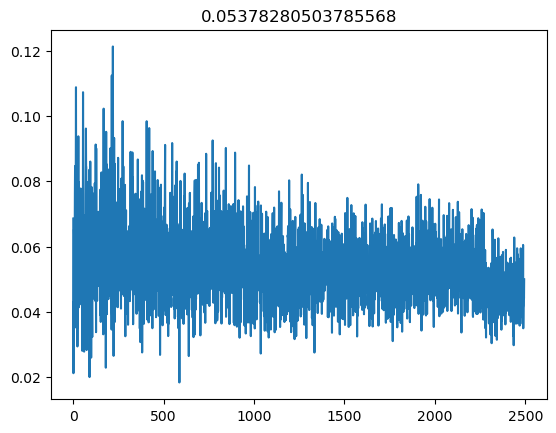

In [11]:
from matplotlib import pyplot as plt
plt.plot([i for i in range(len(loss))],[i[0] for i in loss])
plt.title(np.average([i[0] for i in loss]))
plt.savefig("network_loss.png")

In [12]:
for tupla in loss[:2000]:
    print(tupla[0],str(tupla[1]))

0.06858704867959606 Instance(100,23,#8754104858877)
0.021239609179964578 Instance(100,40,#8754103328605)
0.04305172053398849 Instance(100,62,#8754103214901)
0.040387375804045125 Instance(100,88,#8754101582441)
0.0652595626174468 Instance(100,26,#8754100934745)
0.05973030136896709 Instance(100,97,#8754100652029)
0.04656077343760224 Instance(100,82,#8754109616505)
0.05029358137660512 Instance(100,79,#8754097748989)
0.06624368924800433 Instance(100,90,#8754096961533)
0.07640412207160859 Instance(100,94,#8754096413693)
0.0846667373742195 Instance(100,90,#8754095628285)
0.05881809805294878 Instance(100,65,#8754094900205)
0.036922424049919626 Instance(100,90,#8754094052349)
0.058963701477967805 Instance(100,80,#8754093261821)
0.08776765451655624 Instance(100,87,#8754092473341)
0.10877048192934444 Instance(100,70,#8754091749357)
0.07840237372766276 Instance(100,54,#8754090900477)
0.035151155098968954 Instance(100,71,#8754090109949)
0.037461233587903466 Instance(100,81,#8754109037945)
0.089882

Presicion 90.155%
STD 1.891%


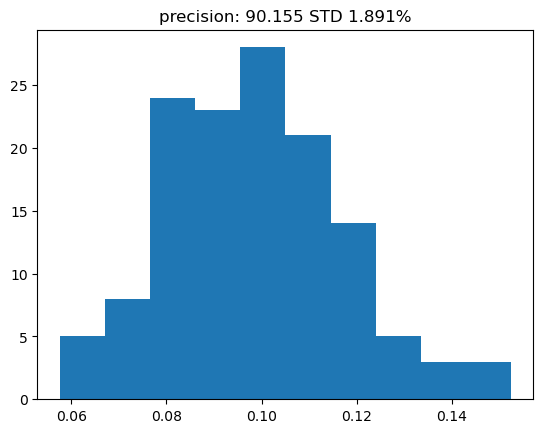

In [13]:
losses = []
with torch.no_grad():
    for instance in evaluation_instances:
        x = heu.gen_x(instance).T
        y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
        if len(y) == 0:
            continue
        y_pred = heu.net(x)
        eval_loss = heu.criterion(y,y_pred)
        losses.append(eval_loss)
precision = (1-np.average(losses))*100
desviacion_estandar = (np.std(losses))*100
print(f"Presicion {np.round(precision,3)}%")
print(f"STD {np.round(desviacion_estandar,3)}%")
plt.title(f"precision: {np.round(precision,3)} STD {np.round(desviacion_estandar,3)}%")
plt.hist(losses)
plt.savefig("network_precision.png")